In [3]:
#pip install torch torchvision matplotlib

Note: you may need to restart the kernel to use updated packages.


In [1]:
# 필요한 라이브러리 불러오기
import torch
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from pathlib import Path
import numpy as np
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'



In [2]:
# 하드웨어 설정
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
# 데이터 전처리
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),  # 흑백으로 변환
    transforms.Resize((128, 128)),  # 크기를 조정
    transforms.CenterCrop((64, 64)),  # 중심을 기준으로 크롭 (추천: 64x64)
    transforms.ToTensor(),           # Tensor로 변환
    transforms.Normalize((0.5,), (0.5,))  # 정규화
])


In [4]:
# 데이터 로드
train_data = datasets.ImageFolder(root="./data/train", transform=transform)
valid_data = datasets.ImageFolder(root="./data/valid", transform=transform)

train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
valid_loader = DataLoader(valid_data, batch_size=32, shuffle=False)


In [5]:
def forward(self, x):
    x = self.conv_layers(x)
    print(f"CNN Output Shape: {x.shape}")  # CNN 출력 크기 확인
    x = x.view(x.size(0), -1)
    x = self.fc_layers(x)
    return x


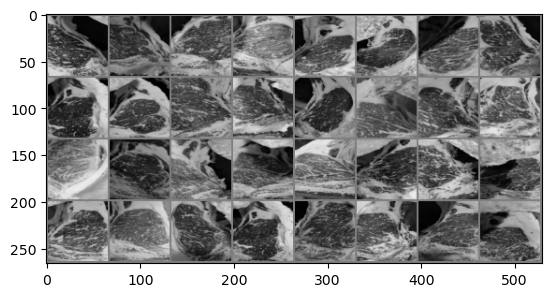

Labels: tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0])


In [6]:
import torchvision
# 이미지 시각화 함수
def imshow(img):
    # 정규화를 다시 되돌림
    img = img / 2 + 0.5  # mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5] 복원
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))  # (C, H, W) -> (H, W, C)
    plt.show()

# 데이터 확인
data_iter = iter(valid_loader)
images, labels = next(data_iter)

# 이미지를 격자로 배치하고 출력
imshow(torchvision.utils.make_grid(images))
print('Labels:', labels)

In [7]:
print(f"Train dataset size: {len(train_data)}")
print(f"Validation dataset size: {len(valid_data)}")


Train dataset size: 1515
Validation dataset size: 500


In [8]:
images, labels = next(iter(train_loader))
print(f"Sample batch shape: {images.shape}, Labels: {labels}")


Sample batch shape: torch.Size([32, 1, 64, 64]), Labels: tensor([2, 1, 1, 1, 3, 1, 0, 1, 1, 2, 0, 4, 3, 1, 1, 0, 1, 4, 0, 2, 0, 2, 1, 0,
        3, 3, 3, 2, 3, 3, 2, 1])


In [12]:
import torch
from torch import nn, optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

# 디바이스 설정
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 데이터 전처리
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),  # Grayscale로 변환
    transforms.Resize((150, 150)),  # 크기를 먼저 늘림
    transforms.CenterCrop((64, 64)),  # 중심 크롭
    transforms.ToTensor(),  # Tensor 변환
    transforms.Normalize(mean=[0.5], std=[0.5])  # 정규화
])

# 데이터 로드
train_data = datasets.ImageFolder(root="./data/train", transform=transform)
valid_data = datasets.ImageFolder(root="./data/valid", transform=transform)

train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
valid_loader = DataLoader(valid_data, batch_size=32, shuffle=False)


# CNN 모델 정의
class BeefClassifier(nn.Module):
    def __init__(self):
        super(BeefClassifier, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1),  # 입력 채널을 1로 변경
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.fc_layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128 * 8 * 8, 256),  # CNN 출력 크기에 맞게 수정
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, len(train_data.classes))
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = self.fc_layers(x)
        return x

model = BeefClassifier().to(device)

# 손실 함수 및 옵티마이저 정의
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# 학습 및 검증 함수 정의
def train_model(model, train_loader, valid_loader, criterion, optimizer, epochs):
    train_loss = []
    valid_loss = []
    train_acc = []
    valid_acc = []

    for epoch in range(epochs):
        # Training
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

        train_loss.append(running_loss / len(train_loader))
        train_acc.append(100 * correct / total)

        # Validation
        model.eval()
        running_loss = 0.0
        correct = 0
        total = 0
        with torch.no_grad():
            for images, labels in valid_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                running_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                correct += (predicted == labels).sum().item()
                total += labels.size(0)

        valid_loss.append(running_loss / len(valid_loader))
        valid_acc.append(100 * correct / total)

        print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_loss[-1]:.4f}, Train Acc: {train_acc[-1]:.2f}%, "
              f"Valid Loss: {valid_loss[-1]:.4f}, Valid Acc: {valid_acc[-1]:.2f}%")

    return train_loss, valid_loss, train_acc, valid_acc

# 학습 실행
train_loss, valid_loss, train_acc, valid_acc = train_model(
    model, train_loader, valid_loader, criterion, optimizer, epochs=10
)

# 학습 결과 시각화
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_loss, label='Train Loss')
plt.plot(valid_loss, label='Valid Loss')
plt.title('Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_acc, label='Train Accuracy')
plt.plot(valid_acc, label='Valid Accuracy')
plt.title('Accuracy Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

RuntimeError: mat1 and mat2 shapes cannot be multiplied (32x32768 and 8192x256)

## 크롭 크기 (64,64) 진행했을 경우
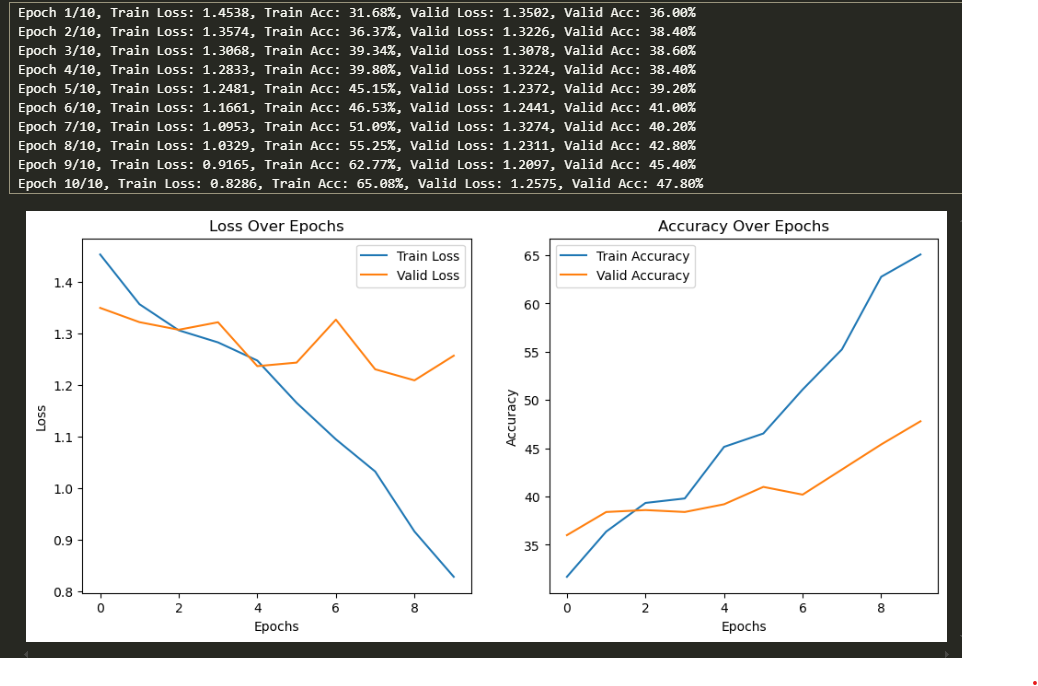

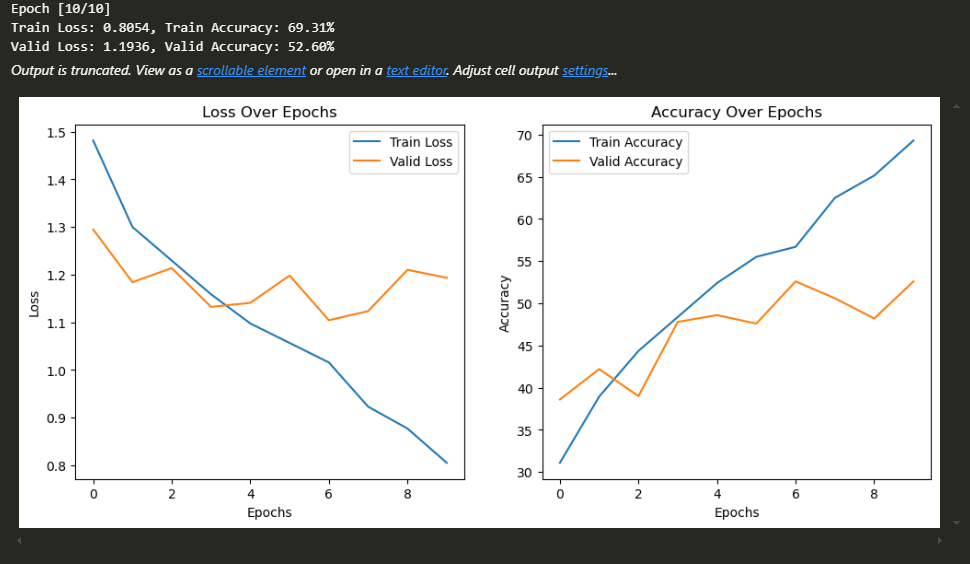


-------------- conv 3, linear 1 ----------------

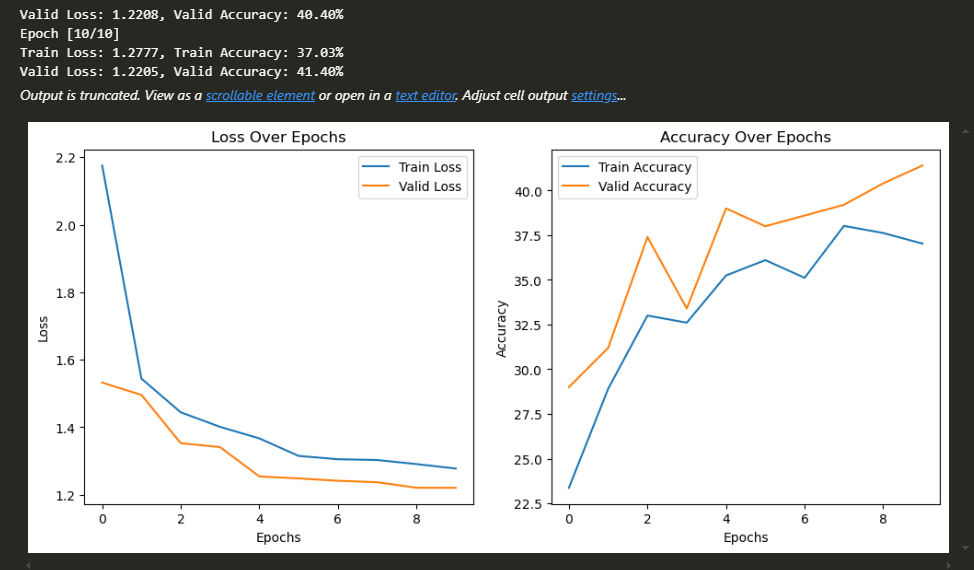

conv 5, Linear 늘리고, 정규화, scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)  # 5 에포크마다 학습률을 0.1배로 감소

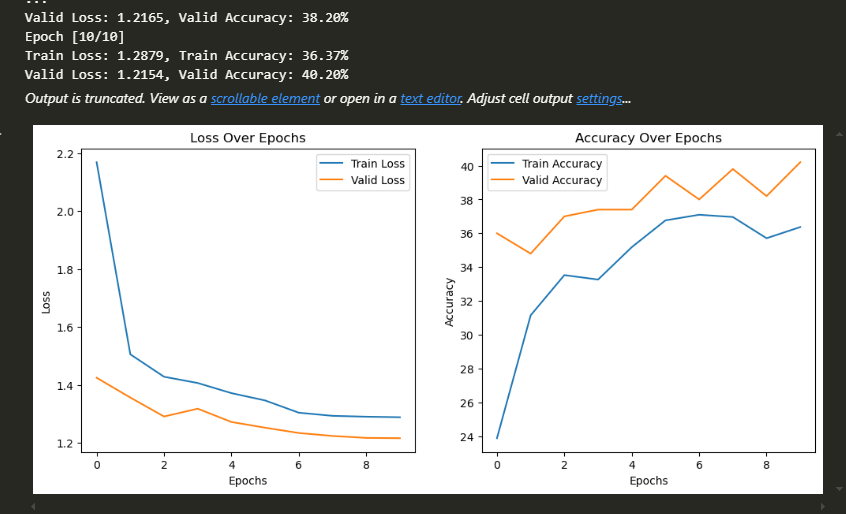

epochs 10 -> 20

Epoch [1/10]
Train Loss: 2.1216, Train Accuracy: 24.88%
Valid Loss: 1.4107, Valid Accuracy: 36.80%
Epoch [2/10]
Train Loss: 1.5146, Train Accuracy: 29.70%
Valid Loss: 1.5906, Valid Accuracy: 22.40%
Epoch [3/10]
Train Loss: 1.3930, Train Accuracy: 33.86%
Valid Loss: 1.2767, Valid Accuracy: 36.20%
Epoch [4/10]
Train Loss: 1.3768, Train Accuracy: 35.78%
Valid Loss: 1.2329, Valid Accuracy: 41.20%
Epoch [5/10]
Train Loss: 1.3425, Train Accuracy: 35.64%
Valid Loss: 1.2407, Valid Accuracy: 39.20%
Epoch [6/10]
Train Loss: 1.3043, Train Accuracy: 38.75%
Valid Loss: 1.2101, Valid Accuracy: 41.00%
Epoch [7/10]
Train Loss: 1.2789, Train Accuracy: 36.63%
Valid Loss: 1.2094, Valid Accuracy: 39.20%
Epoch [8/10]
Train Loss: 1.2610, Train Accuracy: 38.88%
Valid Loss: 1.1883, Valid Accuracy: 40.20%
Epoch [9/10]
Train Loss: 1.2464, Train Accuracy: 40.66%
Valid Loss: 1.1862, Valid Accuracy: 41.00%
Epoch [10/10]
Train Loss: 1.2377, Train Accuracy: 38.68%
Valid Loss: 1.1906, Valid Accuracy: 42.80%


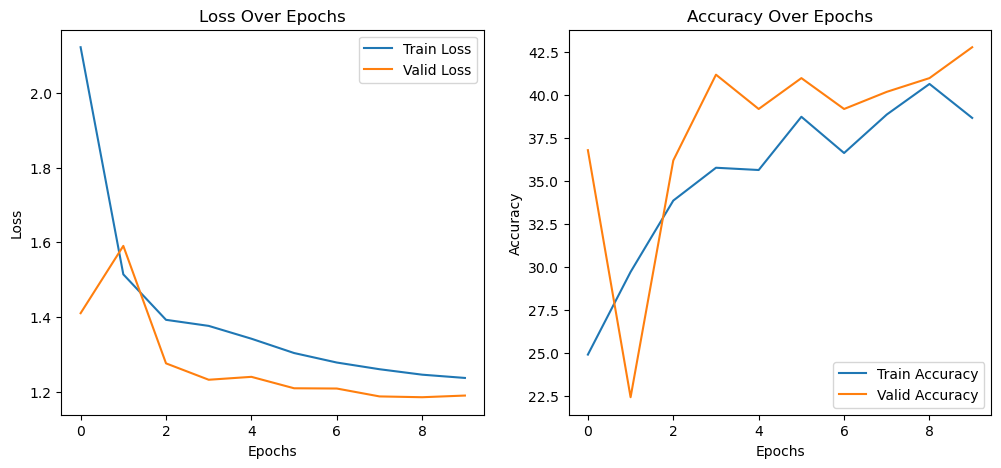

FileNotFoundError: Couldn't find any class folder in ./data/test.

In [18]:
# 필요한 라이브러리 불러오기
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

# 하드웨어 설정
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 데이터 전처리 (데이터 증강 적용)
transform_train = transforms.Compose([
    transforms.Resize((150, 150)),                # 크기를 먼저 늘림
    transforms.Grayscale(num_output_channels=1),  # 흑백으로 변환
    transforms.CenterCrop((128, 128)),            # 중심 크롭
    transforms.RandomHorizontalFlip(),            # 좌우 반전
    transforms.RandomRotation(15),               # 랜덤 회전
    transforms.ColorJitter(brightness=0.2,       # 밝기 조정
                           contrast=0.2,
                           saturation=0.2,
                           hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])  # 정규화
])

transform_valid = transforms.Compose([
    transforms.Resize((150, 150)),  # 크기를 먼저 늘림
    transforms.Grayscale(num_output_channels=1),  # 흑백으로 변환
    transforms.CenterCrop((128, 128)),  # 중심 크롭
    transforms.ToTensor(),  # Tensor 변환
    transforms.Normalize(mean=[0.5], std=[0.5])  # 정규화
])

# 데이터 로드
train_data = datasets.ImageFolder(root="./data/train", transform=transform_train)
valid_data = datasets.ImageFolder(root="./data/valid", transform=transform_valid)

train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
valid_loader = DataLoader(valid_data, batch_size=32, shuffle=False)

# CNN 모델 정의
class BeefClassifier(nn.Module):
    def __init__(self):
        super(BeefClassifier, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1),  # 입력 채널을 1로 변경
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.fc_layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(512 * 4 * 4, 1024),  # CNN 출력 크기에 맞게 수정
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, len(train_data.classes))
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = self.fc_layers(x)
        return x

model = BeefClassifier().to(device)

# 손실 함수 및 옵티마이저 정의
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# 학습률 스케줄러 정의
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)  # 5 에포크마다 학습률을 0.1배로 감소

# 학습 및 검증 함수 정의
def train_model(model, train_loader, valid_loader, criterion, optimizer, scheduler, epochs=30):
    train_loss_list = []
    valid_loss_list = []
    train_acc_list = []
    valid_acc_list = []

    for epoch in range(epochs):
        # Training
        model.train()
        train_loss = 0.0
        correct = 0
        total = 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

        train_loss_list.append(train_loss / len(train_loader))
        train_acc_list.append(100. * correct / total)

        # Validation
        model.eval()
        valid_loss = 0.0
        correct = 0
        total = 0

        with torch.no_grad():
            for images, labels in valid_loader:
                images, labels = images.to(device), labels.to(device)

                outputs = model(images)
                loss = criterion(outputs, labels)

                valid_loss += loss.item()
                _, predicted = outputs.max(1)
                total += labels.size(0)
                correct += predicted.eq(labels).sum().item()

        valid_loss_list.append(valid_loss / len(valid_loader))
        valid_acc_list.append(100. * correct / total)

        print(f"Epoch [{epoch+1}/{epochs}]\n"
              f"Train Loss: {train_loss_list[-1]:.4f}, Train Accuracy: {train_acc_list[-1]:.2f}%\n"
              f"Valid Loss: {valid_loss_list[-1]:.4f}, Valid Accuracy: {valid_acc_list[-1]:.2f}%",
              flush=True)

        # 학습률 스케줄러 업데이트
        scheduler.step()

    return train_loss_list, valid_loss_list, train_acc_list, valid_acc_list

# 학습 실행
train_loss, valid_loss, train_acc, valid_acc = train_model(model, train_loader, valid_loader, criterion, optimizer, scheduler, epochs=10)

# 학습 결과 시각화
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_loss, label='Train Loss')
plt.plot(valid_loss, label='Valid Loss')
plt.title('Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_acc, label='Train Accuracy')
plt.plot(valid_acc, label='Valid Accuracy')
plt.title('Accuracy Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

# 테스트 함수 정의
def test_model(model, test_loader, device):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    print(f'Accuracy of the model on the test images: {100 * correct / total:.2f}%')

# 테스트 데이터 로드
test_data = datasets.ImageFolder(root="./data/test", transform=transform_valid)
test_loader = DataLoader(test_data, batch_size=32, shuffle=False)

# 모델 테스트
test_model(model, test_loader, device)

Conv 3층, Linear 늘리고, 스케줄러 추가, epochs = 20
학습률 조절 : 0.001 -> 0.0001 

Epoch 1/20, Train Loss: 1.5502, Train Acc: 28.38%, Valid Loss: 1.3694, Valid Acc: 33.00%
Epoch 2/20, Train Loss: 1.4112, Train Acc: 34.13%, Valid Loss: 1.3250, Valid Acc: 35.60%
Epoch 3/20, Train Loss: 1.3627, Train Acc: 38.48%, Valid Loss: 1.3049, Valid Acc: 35.80%
Epoch 4/20, Train Loss: 1.3252, Train Acc: 38.28%, Valid Loss: 1.2794, Valid Acc: 37.20%
Epoch 5/20, Train Loss: 1.3164, Train Acc: 38.75%, Valid Loss: 1.2573, Valid Acc: 36.80%
Epoch 6/20, Train Loss: 1.2775, Train Acc: 41.45%, Valid Loss: 1.2484, Valid Acc: 36.80%
Epoch 7/20, Train Loss: 1.2517, Train Acc: 43.04%, Valid Loss: 1.2422, Valid Acc: 36.20%
Epoch 8/20, Train Loss: 1.2515, Train Acc: 42.11%, Valid Loss: 1.2380, Valid Acc: 36.60%
Epoch 9/20, Train Loss: 1.2398, Train Acc: 42.77%, Valid Loss: 1.2324, Valid Acc: 37.20%
Epoch 10/20, Train Loss: 1.2316, Train Acc: 43.17%, Valid Loss: 1.2323, Valid Acc: 37.60%
Epoch 11/20, Train Loss: 1.2284, Train Acc: 43.37%, Valid Loss: 1.2316, Valid Acc: 37.60%
Epoch 12/20, Train 

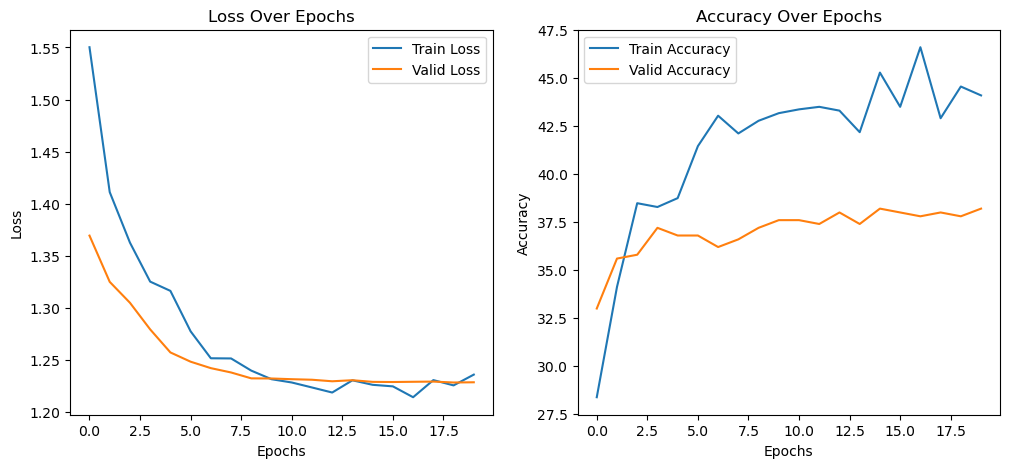

FileNotFoundError: Couldn't find any class folder in ./data/test.

In [20]:
import torch
from torch import nn, optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

# 디바이스 설정
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 데이터 전처리
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),  # Grayscale로 변환
    transforms.Resize((150, 150)),  # 크기를 먼저 늘림
    transforms.CenterCrop((64, 64)),  # 중심 크롭
    transforms.ToTensor(),  # Tensor 변환
    transforms.Normalize(mean=[0.5], std=[0.5])  # 정규화
])

# 데이터 로드
train_data = datasets.ImageFolder(root="./data/train", transform=transform)
valid_data = datasets.ImageFolder(root="./data/valid", transform=transform)

train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
valid_loader = DataLoader(valid_data, batch_size=32, shuffle=False)

# CNN 모델 정의
class BeefClassifier(nn.Module):
    def __init__(self):
        super(BeefClassifier, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1),  # 입력 채널을 1로 변경
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.fc_layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128 * 8 * 8, 512),  # CNN 출력 크기에 맞게 수정
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, len(train_data.classes))
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = self.fc_layers(x)
        return x

model = BeefClassifier().to(device)

# 손실 함수 및 옵티마이저 정의
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)  # 학습률 감소

# 학습률 스케줄러 정의
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)  # 5 에포크마다 학습률을 0.1배로 감소

# 학습 및 검증 함수 정의
def train_model(model, train_loader, valid_loader, criterion, optimizer, scheduler, epochs):
    train_loss = []
    valid_loss = []
    train_acc = []
    valid_acc = []

    for epoch in range(epochs):
        # Training
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

        train_loss.append(running_loss / len(train_loader))
        train_acc.append(100 * correct / total)

        # Validation
        model.eval()
        running_loss = 0.0
        correct = 0
        total = 0
        with torch.no_grad():
            for images, labels in valid_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                running_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                correct += (predicted == labels).sum().item()
                total += labels.size(0)

        valid_loss.append(running_loss / len(valid_loader))
        valid_acc.append(100 * correct / total)

        print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_loss[-1]:.4f}, Train Acc: {train_acc[-1]:.2f}%, "
              f"Valid Loss: {valid_loss[-1]:.4f}, Valid Acc: {valid_acc[-1]:.2f}%")

        # 학습률 스케줄러 업데이트
        scheduler.step()

    return train_loss, valid_loss, train_acc, valid_acc

# 학습 실행
train_loss, valid_loss, train_acc, valid_acc = train_model(
    model, train_loader, valid_loader, criterion, optimizer, scheduler, epochs=20
)

# 학습 결과 시각화
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_loss, label='Train Loss')
plt.plot(valid_loss, label='Valid Loss')
plt.title('Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_acc, label='Train Accuracy')
plt.plot(valid_acc, label='Valid Accuracy')
plt.title('Accuracy Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

# 테스트 함수 정의
def test_model(model, test_loader, device):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    print(f'Accuracy of the model on the test images: {100 * correct / total:.2f}%')

# 테스트 데이터 로드
test_data = datasets.ImageFolder(root="./data/test", transform=transform)
test_loader = DataLoader(test_data, batch_size=32, shuffle=False)

# 모델 테스트
test_model(model, test_loader, device)

RGB 이미지를 사용하여 CNN 모델을 학습

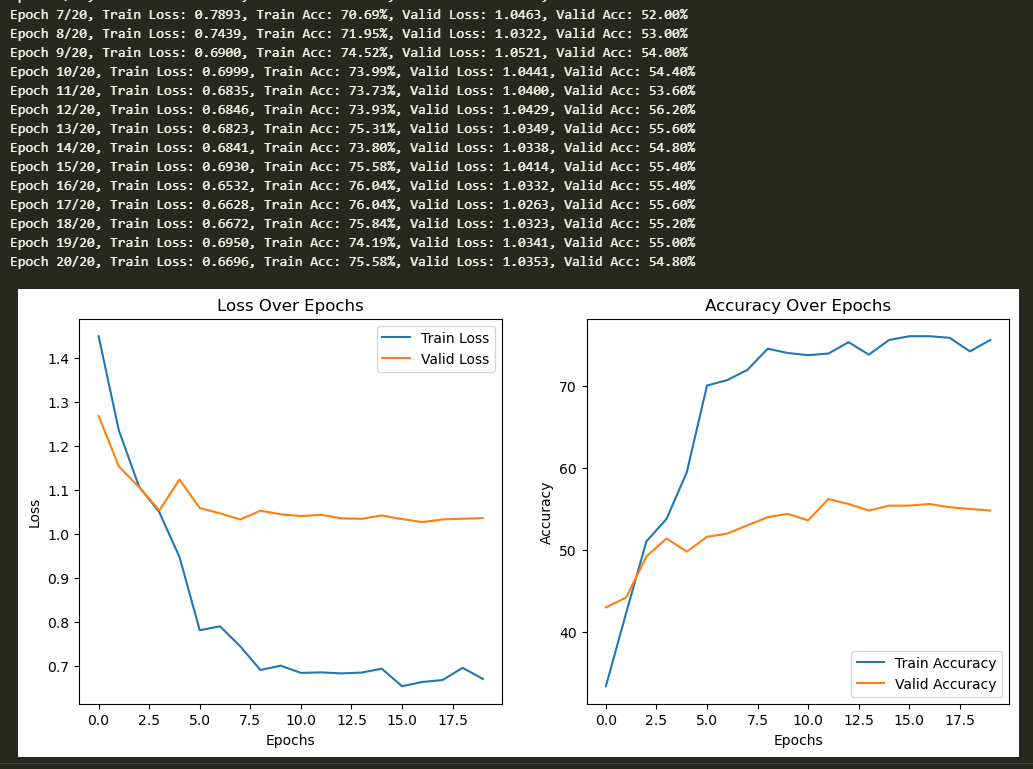

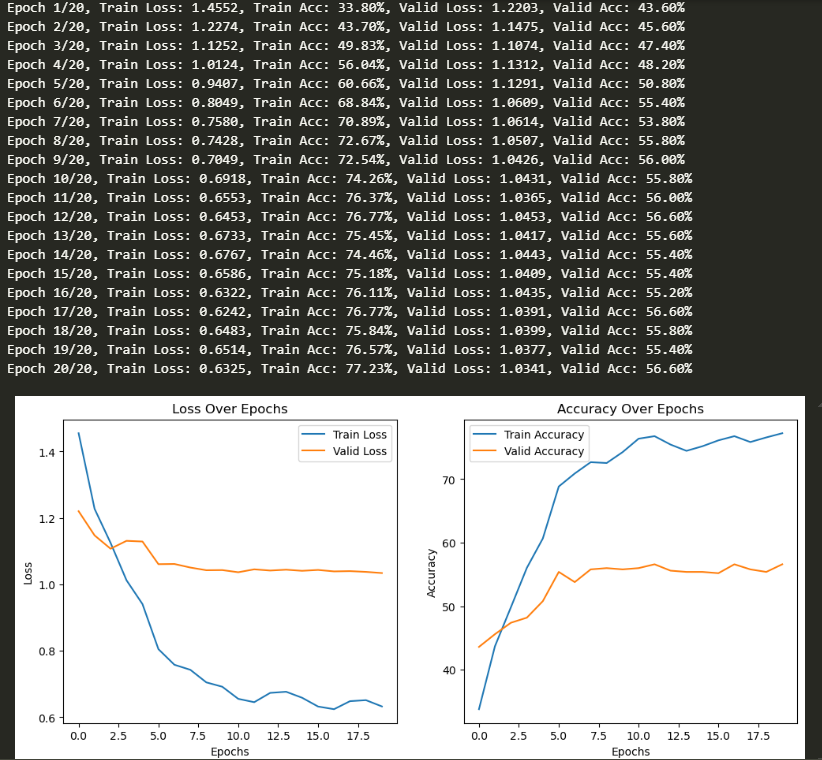

pre-trained model 사용하여 학습

RGB 이미지를 사용하여 CNN 모델을 학습 3 (epochs 50)

Epoch 1/50, Train Loss: 1.4537, Train Acc: 34.13%, Valid Loss: 1.2366, Valid Acc: 38.20%
Epoch 2/50, Train Loss: 1.2111, Train Acc: 43.17%, Valid Loss: 1.1288, Valid Acc: 48.40%
Epoch 3/50, Train Loss: 1.1094, Train Acc: 50.89%, Valid Loss: 1.2280, Valid Acc: 42.00%
Epoch 4/50, Train Loss: 1.0374, Train Acc: 55.71%, Valid Loss: 1.0628, Valid Acc: 50.60%
Epoch 5/50, Train Loss: 0.9340, Train Acc: 59.74%, Valid Loss: 1.0841, Valid Acc: 52.00%
Epoch 6/50, Train Loss: 0.8314, Train Acc: 67.59%, Valid Loss: 1.0076, Valid Acc: 55.20%
Epoch 7/50, Train Loss: 0.8237, Train Acc: 67.72%, Valid Loss: 1.0054, Valid Acc: 57.00%
Epoch 8/50, Train Loss: 0.7537, Train Acc: 70.56%, Valid Loss: 0.9985, Valid Acc: 56.80%
Epoch 9/50, Train Loss: 0.7459, Train Acc: 71.62%, Valid Loss: 0.9935, Valid Acc: 56.60%
Epoch 10/50, Train Loss: 0.7085, Train Acc: 72.67%, Valid Loss: 0.9983, Valid Acc: 58.00%
Epoch 11/50, Train Loss: 0.6743, Train Acc: 75.84%, Valid Loss: 0.9910, Valid Acc: 58.60%
Epoch 12/50, Train 

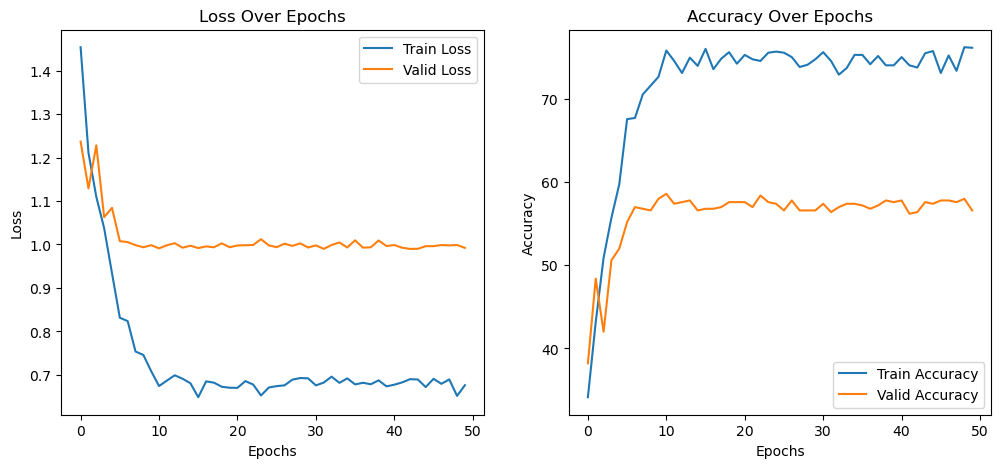

Accuracy of the model on the test images: 100.00%


In [26]:
import torch
from torch import nn, optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
import matplotlib.pyplot as plt

# 디바이스 설정
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 데이터 전처리 및 증강
transform_train = transforms.Compose([
    transforms.Resize((150, 150)),
    transforms.CenterCrop((128, 128)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

transform_valid = transforms.Compose([
    transforms.Resize((150, 150)),
    transforms.CenterCrop((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# 데이터 로드
train_data = datasets.ImageFolder(root="./data/train", transform=transform_train)
valid_data = datasets.ImageFolder(root="./data/valid", transform=transform_valid)

train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
valid_loader = DataLoader(valid_data, batch_size=32, shuffle=False)

# 사전 학습된 모델 (ResNet-18) 로드 및 수정
class FineTunedResNet(nn.Module):
    def __init__(self, num_classes):
        super(FineTunedResNet, self).__init__()
        self.base_model = models.resnet18(pretrained=True)
        self.base_model.fc = nn.Sequential(
            nn.Linear(self.base_model.fc.in_features, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        return self.base_model(x)

model = FineTunedResNet(num_classes=len(train_data.classes)).to(device)

# 손실 함수 및 옵티마이저 정의
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

# 학습률 스케줄러 정의
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

# 학습 및 검증 함수 정의
def train_model(model, train_loader, valid_loader, criterion, optimizer, scheduler, epochs=50):
    train_loss = []
    valid_loss = []
    train_acc = []
    valid_acc = []

    for epoch in range(epochs):
        # Training
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

        train_loss.append(running_loss / len(train_loader))
        train_acc.append(100 * correct / total)

        # Validation
        model.eval()
        running_loss = 0.0
        correct = 0
        total = 0
        with torch.no_grad():
            for images, labels in valid_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                running_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                correct += (predicted == labels).sum().item()
                total += labels.size(0)

        valid_loss.append(running_loss / len(valid_loader))
        valid_acc.append(100 * correct / total)

        print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_loss[-1]:.4f}, Train Acc: {train_acc[-1]:.2f}%, "
              f"Valid Loss: {valid_loss[-1]:.4f}, Valid Acc: {valid_acc[-1]:.2f}%")

        # 학습률 스케줄러 업데이트
        scheduler.step()

    return train_loss, valid_loss, train_acc, valid_acc

# 학습 실행
train_loss, valid_loss, train_acc, valid_acc = train_model(
    model, train_loader, valid_loader, criterion, optimizer, scheduler, epochs=50
)

# 학습 결과 시각화
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_loss, label='Train Loss')
plt.plot(valid_loss, label='Valid Loss')
plt.title('Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_acc, label='Train Accuracy')
plt.plot(valid_acc, label='Valid Accuracy')
plt.title('Accuracy Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

# 테스트 함수 정의
def test_model(model, test_loader, device):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    print(f'Accuracy of the model on the test images: {100 * correct / total:.2f}%')

# 테스트 데이터 로드
test_data = datasets.ImageFolder(root="./data/test", transform=transform_valid)
test_loader = DataLoader(test_data, batch_size=32, shuffle=False)

# 모델 테스트
test_model(model, test_loader, device)

c:\Users\it\anaconda3\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\it\anaconda3\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to C:\Users\it/.cache\torch\hub\checkpoints\vgg16-397923af.pth
100%|██████████| 528M/528M [00:05<00:00, 104MB/s]  


Epoch 1/20, Train Loss: 1.4483, Train Acc: 32.48%, Valid Loss: 1.2109, Valid Acc: 39.20%
Epoch 2/20, Train Loss: 1.2926, Train Acc: 39.80%, Valid Loss: 1.1969, Valid Acc: 38.20%
Epoch 3/20, Train Loss: 1.2050, Train Acc: 42.24%, Valid Loss: 1.1408, Valid Acc: 45.40%
Epoch 4/20, Train Loss: 1.1451, Train Acc: 47.06%, Valid Loss: 1.0971, Valid Acc: 46.00%
Epoch 5/20, Train Loss: 1.1257, Train Acc: 47.39%, Valid Loss: 1.1458, Valid Acc: 44.80%
Epoch 6/20, Train Loss: 1.0358, Train Acc: 52.41%, Valid Loss: 1.0509, Valid Acc: 51.40%
Epoch 7/20, Train Loss: 0.9844, Train Acc: 55.25%, Valid Loss: 1.0410, Valid Acc: 49.40%
Epoch 8/20, Train Loss: 0.9686, Train Acc: 57.43%, Valid Loss: 1.0484, Valid Acc: 51.00%
Epoch 9/20, Train Loss: 0.9724, Train Acc: 56.90%, Valid Loss: 1.0732, Valid Acc: 50.40%
Epoch 10/20, Train Loss: 0.9494, Train Acc: 57.29%, Valid Loss: 1.0203, Valid Acc: 51.40%
Epoch 11/20, Train Loss: 0.9177, Train Acc: 60.07%, Valid Loss: 1.0243, Valid Acc: 50.40%
Epoch 12/20, Train 

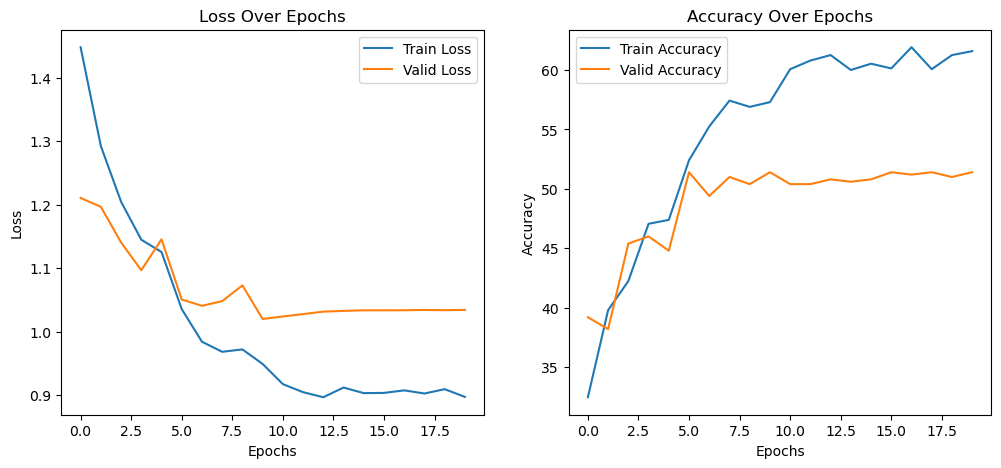

Accuracy of the model on the test images: 51.40%
Confusion Matrix:
[[43 41 15  1  0]
 [34 36 23  7  0]
 [34 21 33 12  0]
 [ 6 19 15 57  3]
 [ 1  2  0  9 88]]

Classification Report:
              precision    recall  f1-score   support

           A       0.36      0.43      0.39       100
           B       0.30      0.36      0.33       100
           C       0.38      0.33      0.35       100
           D       0.66      0.57      0.61       100
           E       0.97      0.88      0.92       100

    accuracy                           0.51       500
   macro avg       0.54      0.51      0.52       500
weighted avg       0.54      0.51      0.52       500



In [27]:
#VGG 모델 사용

import torch
from torch import nn, optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report

# 디바이스 설정
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 데이터 전처리 및 증강
transform_train = transforms.Compose([
    transforms.Resize((150, 150)),
    transforms.CenterCrop((128, 128)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) # 정규화 
    # ImageNet 데이터셋의 평균과 표준편차 
])

transform_valid = transforms.Compose([
    transforms.Resize((150, 150)),
    transforms.CenterCrop((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) # 정규화
])

# 데이터 로드
train_data = datasets.ImageFolder(root="./data/train", transform=transform_train)
valid_data = datasets.ImageFolder(root="./data/valid", transform=transform_valid)

train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
valid_loader = DataLoader(valid_data, batch_size=32, shuffle=False)

# 사전 학습된 VGG16 모델 로드 및 수정
class FineTunedVGG(nn.Module):
    def __init__(self, num_classes):
        super(FineTunedVGG, self).__init__()
        self.base_model = models.vgg16(pretrained=True)
        self.base_model.classifier[6] = nn.Linear(self.base_model.classifier[6].in_features, num_classes)

    def forward(self, x):
        return self.base_model(x)

model = FineTunedVGG(num_classes=len(train_data.classes)).to(device)

# 손실 함수 및 옵티마이저 정의
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

# 학습률 스케줄러 정의
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

# 학습 및 검증 함수 정의
def train_model(model, train_loader, valid_loader, criterion, optimizer, scheduler, epochs=20):
    train_loss = []
    valid_loss = []
    train_acc = []
    valid_acc = []

    for epoch in range(epochs):
        # Training
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

        train_loss.append(running_loss / len(train_loader))
        train_acc.append(100 * correct / total)

        # Validation
        model.eval()
        running_loss = 0.0
        correct = 0
        total = 0
        with torch.no_grad():
            for images, labels in valid_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                running_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                correct += (predicted == labels).sum().item()
                total += labels.size(0)

        valid_loss.append(running_loss / len(valid_loader))
        valid_acc.append(100 * correct / total)

        print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_loss[-1]:.4f}, Train Acc: {train_acc[-1]:.2f}%, "
              f"Valid Loss: {valid_loss[-1]:.4f}, Valid Acc: {valid_acc[-1]:.2f}%")

        # 학습률 스케줄러 업데이트
        scheduler.step()

    return train_loss, valid_loss, train_acc, valid_acc

# 학습 실행
train_loss, valid_loss, train_acc, valid_acc = train_model(
    model, train_loader, valid_loader, criterion, optimizer, scheduler, epochs=20
)

# 학습 결과 시각화
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_loss, label='Train Loss')
plt.plot(valid_loss, label='Valid Loss')
plt.title('Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_acc, label='Train Accuracy')
plt.plot(valid_acc, label='Valid Accuracy')
plt.title('Accuracy Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

# 테스트 함수 정의
def test_model(model, test_loader, device, class_names):
    model.eval()
    correct = 0
    total = 0
    all_labels = []
    all_preds = []
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(predicted.cpu().numpy())
    print(f'Accuracy of the model on the test images: {100 * correct / total:.2f}%')

    # 혼동 행렬 및 클래스별 정확도 계산
    cm = confusion_matrix(all_labels, all_preds)
    print("Confusion Matrix:")
    print(cm)
    print("\nClassification Report:")
    print(classification_report(all_labels, all_preds, target_names=class_names))

# 클래스 이름 가져오기
class_names = train_data.classes

# 모델 테스트
test_model(model, valid_loader, device, class_names)

행은 실제 클래스, 열은 예측된 클래스

A 클래스: 실제 A 클래스 중 43개가 A로, 41개가 B로, 15개가 C로, 1개가 D로 예측되었습니다.
B 클래스: 실제 B 클래스 중 34개가 A로, 36개가 B로, 23개가 C로, 7개가 D로 예측되었습니다.
C 클래스: 실제 C 클래스 중 34개가 A로, 21개가 B로, 33개가 C로, 12개가 D로 예측되었습니다.
D 클래스: 실제 D 클래스 중 6개가 A로, 19개가 B로, 15개가 C로, 57개가 D로, 3개가 E로 예측되었습니다.
E 클래스: 실제 E 클래스 중 1개가 A로, 2개가 B로, 9개가 D로, 88개가 E로 예측되었습니다.
분류 보고서
분류 보고서는 각 클래스에 대한 정밀도, 재현율, F1-스코어, 지원 수를 제공합니다.

정밀도(Precision): 모델이 해당 클래스로 예측한 것 중 실제로 해당 클래스인 비율입니다.

A: 0.36
B: 0.30
C: 0.38
D: 0.66
E: 0.97
재현율(Recall): 실제 해당 클래스 중 모델이 해당 클래스로 올바르게 예측한 비율입니다.

A: 0.43
B: 0.36
C: 0.33
D: 0.57
E: 0.88
F1-스코어(F1-score): 정밀도와 재현율의 조화 평균입니다.

A: 0.39
B: 0.33
C: 0.35
D: 0.61
E: 0.92
지원 수(Support): 각 클래스의 실제 샘플 수입니다.

A: 100
B: 100
C: 100
D: 100
E: 100
전체 정확도(Accuracy): 0.51 (51.40%)

In [29]:
import torch
from torch import nn, optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report

# 디바이스 설정
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 데이터 전처리 및 증강
transform_train = transforms.Compose([
    transforms.Resize((150, 150)),
    transforms.CenterCrop((128, 128)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

transform_valid = transforms.Compose([
    transforms.Resize((150, 150)),
    transforms.CenterCrop((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# 데이터 로드
train_data = datasets.ImageFolder(root="./data/train", transform=transform_train)
valid_data = datasets.ImageFolder(root="./data/valid", transform=transform_valid)

train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
valid_loader = DataLoader(valid_data, batch_size=32, shuffle=False)

# 사전 학습된 VGG16 모델 로드 및 수정
class FineTunedVGG(nn.Module):
    def __init__(self, num_classes):
        super(FineTunedVGG, self).__init__()
        self.base_model = models.vgg16(pretrained=True)
        self.base_model.classifier[6] = nn.Sequential(
            nn.Linear(self.base_model.classifier[6].in_features, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        return self.base_model(x)

model = FineTunedVGG(num_classes=len(train_data.classes)).to(device)

# 손실 함수 및 옵티마이저 정의
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

# 학습률 스케줄러 정의
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

# 조기 종료 클래스 정의
class EarlyStopping:
    def __init__(self, patience=5, delta=0):
        self.patience = patience
        self.delta = delta
        self.best_score = None
        self.early_stop = False
        self.counter = 0

    def __call__(self, val_loss, model):
        score = -val_loss
        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        torch.save(model.state_dict(), 'checkpoint.pt')

# 학습 및 검증 함수 정의
def train_model(model, train_loader, valid_loader, criterion, optimizer, scheduler, epochs=20, patience=5):
    train_loss = []
    valid_loss = []
    train_acc = []
    valid_acc = []

    early_stopping = EarlyStopping(patience=patience)

    for epoch in range(epochs):
        # Training
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

        train_loss.append(running_loss / len(train_loader))
        train_acc.append(100 * correct / total)

        # Validation
        model.eval()
        running_loss = 0.0
        correct = 0
        total = 0
        with torch.no_grad():
            for images, labels in valid_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                running_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                correct += (predicted == labels).sum().item()
                total += labels.size(0)

        valid_loss.append(running_loss / len(valid_loader))
        valid_acc.append(100 * correct / total)

        print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_loss[-1]:.4f}, Train Acc: {train_acc[-1]:.2f}%, "
              f"Valid Loss: {valid_loss[-1]:.4f}, Valid Acc: {valid_acc[-1]:.2f}%")

        # 조기 종료 확인
        early_stopping(valid_loss[-1], model)
        if early_stopping.early_stop:
            print("Early stopping")
            break

        # 학습률 스케줄러 업데이트
        scheduler.step()

    return train_loss, valid_loss, train_acc, valid_acc

# 학습 실행
train_loss, valid_loss, train_acc, valid_acc = train_model(
    model, train_loader, valid_loader, criterion, optimizer, scheduler, epochs=20, patience=5
)

# 학습 결과 시각화
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_loss, label='Train Loss')
plt.plot(valid_loss, label='Valid Loss')
plt.title('Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_acc, label='Train Accuracy')
plt.plot(valid_acc, label='Valid Accuracy')
plt.title('Accuracy Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

# 테스트 함수 정의
def test_model(model, test_loader, device, class_names):
    model.eval()
    correct = 0
    total = 0
    all_labels = []
    all_preds = []
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(predicted.cpu().numpy())
    print(f'Accuracy of the model on the test images: {100 * correct / total:.2f}%')

    # 혼동 행렬 및 클래스별 정확도 계산
    cm = confusion_matrix(all_labels, all_preds)
    print("Confusion Matrix:")
    print(cm)
    print("\nClassification Report:")
    print(classification_report(all_labels, all_preds, target_names=class_names))

# 클래스 이름 가져오기
class_names = train_data.classes

# 모델 테스트
test_model(model, valid_loader, device, class_names)

Epoch 1/20, Train Loss: 1.4824, Train Acc: 29.77%, Valid Loss: 1.2910, Valid Acc: 37.40%
Epoch 2/20, Train Loss: 1.2611, Train Acc: 39.08%, Valid Loss: 1.1567, Valid Acc: 41.80%
Epoch 3/20, Train Loss: 1.2847, Train Acc: 38.35%, Valid Loss: 1.1661, Valid Acc: 38.20%
Epoch 4/20, Train Loss: 1.2462, Train Acc: 38.75%, Valid Loss: 1.1936, Valid Acc: 45.00%
Epoch 5/20, Train Loss: 1.1902, Train Acc: 42.77%, Valid Loss: 1.1773, Valid Acc: 42.60%
Epoch 6/20, Train Loss: 1.1250, Train Acc: 47.13%, Valid Loss: 1.1000, Valid Acc: 45.80%
Epoch 7/20, Train Loss: 1.0882, Train Acc: 47.66%, Valid Loss: 1.0642, Valid Acc: 47.60%
Epoch 8/20, Train Loss: 1.0698, Train Acc: 50.76%, Valid Loss: 1.0674, Valid Acc: 47.00%
Epoch 9/20, Train Loss: 1.0542, Train Acc: 51.16%, Valid Loss: 1.1119, Valid Acc: 45.60%
Epoch 10/20, Train Loss: 1.0357, Train Acc: 52.81%, Valid Loss: 1.0423, Valid Acc: 50.00%
Epoch 11/20, Train Loss: 1.0093, Train Acc: 54.13%, Valid Loss: 1.0424, Valid Acc: 50.00%
Epoch 12/20, Train 

KeyboardInterrupt: 